In [1]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# Mute sklearn warnings
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from sklearn.preprocessing import scale
import keras.losses
import tensorflow as tf

from csv import writer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../data_etl.csv',parse_dates=['Date'],index_col='Date')

In [3]:
xDay = 1

In [4]:
shiftXday = xDay * -1
df['xDay_future_close'] = df['spx_close'].shift(shiftXday)
df['xDay_close_future_pct'] = df['xDay_future_close'].pct_change(xDay)
df['xDay_close_pct'] = df['spx_close'].pct_change(xDay)

In [5]:
df['s5th_close_pct'] = df['s5th_close'].pct_change(xDay)
df['s5fi_close_pct'] = df['s5fi_close'].pct_change(xDay)

In [6]:
feature_names = ['ema_signal','usdjpy_macdsignal','dxy_macdsignal','duj_macdsignal','xDay_close_pct','s5th_close_pct','s5fi_close_pct']

In [7]:
df = df.dropna()

In [8]:
features = df[feature_names]
targets = df['xDay_close_future_pct']
targets.head()

Date
2011-06-20    0.013423
2011-06-21   -0.006468
2011-06-22   -0.002828
2011-06-23   -0.011726
2011-06-24    0.009184
Name: xDay_close_future_pct, dtype: float64

In [9]:
train_size = int(0.778 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [10]:
#from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

In [11]:
# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

In [12]:
tensorflow.random.set_seed(3633)
    # Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

    # Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)
    # Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

    # Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)

    
    # Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)



    # Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2)), axis = 1)
print(test_preds[-5:])   
train_rmse = np.sqrt(mean_squared_error(train_targets,train_preds))
test_rmse = np.sqrt(mean_squared_error(test_targets,test_preds))
    
predictions = np.concatenate((train_preds,test_preds),axis=None)
predictions = pd.DataFrame(predictions,columns=['predictions'])
return_data = [df['spx_open'],df['spx_close'],df['xDay_close_future_pct']]
return_header = ["open","close","real_pct"]
df_return = pd.concat(return_data,axis=1,keys=return_header)
df_return = df_return.reset_index()
df_return = pd.concat([df_return,predictions],axis=1)

Epoch 1/25
60/60 [==============================] - 12s 776us/step - loss: 0.0148
Epoch 2/25
60/60 [==============================] - 0s 833us/step - loss: 0.0013
Epoch 3/25
60/60 [==============================] - 0s 773us/step - loss: 7.6889e-04
Epoch 4/25
60/60 [==============================] - 0s 726us/step - loss: 4.2722e-04
Epoch 5/25
60/60 [==============================] - 0s 692us/step - loss: 3.1580e-04
Epoch 6/25
60/60 [==============================] - 0s 820us/step - loss: 2.8429e-04
Epoch 7/25
60/60 [==============================] - 0s 820us/step - loss: 2.3258e-04
Epoch 8/25
60/60 [==============================] - 0s 768us/step - loss: 2.3285e-04
Epoch 9/25
60/60 [==============================] - 0s 768us/step - loss: 2.6893e-04
Epoch 10/25
60/60 [==============================] - 0s 682us/step - loss: 1.9584e-04
Epoch 11/25
60/60 [==============================] - 0s 681us/step - loss: 2.2232e-04
Epoch 12/25
60/60 [==============================] - 0s 794us/step - l

In [13]:
    df_return= df_return.assign(isBuy="")
    row = 0

    for x in df_return['predictions']:
        lastRow = row -1
        if x > -1:

            if df_return['predictions'][row]>0:
                df_return['isBuy'][row] = 1
            else:
                df_return['isBuy'][row] = 0
        row = row +1
    df_return = df_return.assign(signal="hold")
    row = 0
    isBought = 0
    for x in df_return['predictions']:
        lastRow = row -1
        if x > -1 and lastRow > -1:
            #print("lastRow:",lastRow,"row:",row)
            if df_return['isBuy'][0]==1:
                df_return['signal'][0] = "buy"
                isBought = 1
            if df_return['isBuy'][row]==1 and df_return['isBuy'][lastRow]==0:
                df_return['signal'][row] = "buy"
                isBought = 1
            if isBought ==1 and df_return['isBuy'][row]==0 and df_return['isBuy'][lastRow]==1:
                df_return['signal'][row] = "sell"
        row = row +1
    df_return= df_return.assign(bsPrice="0")
    row = 0
    for x in df_return['signal']:
        if(row < (df_return.shape[0]-1)):
            tmp = row+1
        if  df_return['signal'][row]== "buy":
          #  df_return['bsPrice'][tmp] = df_return['open'][tmp]
            df_return['bsPrice'][row] = df_return['open'][tmp]

        if df_return['signal'][row] == "sell":
         #   df_return['bsPrice'][tmp] = df_return['open'][tmp]
            df_return['bsPrice'][row] = df_return['open'][tmp]
        row = row +1
    df_return = df_return.assign(point="0")
    row = 0
    bPrice = 0
    sPrice = 0
    for x in df_return['signal']:

        if  df_return['signal'][row]== "buy":
            bPrice = df_return['bsPrice'][row]

        if df_return['signal'][row] == "sell":
            sPrice = df_return['bsPrice'][row]

            df_return['point'][row] = sPrice - bPrice
        row = row +1

<ipython-input-13-1c87875ba212>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-1c87875ba212>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-1c87875ba212>:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-1c87875ba212>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

In [14]:
def spreadReturn(start_date,end_date,year):
    df_point = df_return.loc[df_return['Date'].between(start_date,end_date,inclusive=False)]
    df_point=df_point.reset_index()
    row = 0
    point = 0

    for x in df_point['point']:
        point =int(df_point['point'][row]) + point
        row = row +1
    List = [year,point,train_rmse,test_rmse]
    with open('NN_ensembling_return.csv','a')as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(List)
        f_object.close()

In [15]:
List = ['year','point','train_rmse','test_rmse']
with open('NN_ensembling_return.csv','a')as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(List)
    f_object.close()

In [16]:
spreadReturn("2011-01-01","2011-12-31","2011")
spreadReturn("2012-01-01","2012-12-31","2012")
spreadReturn("2013-01-01","2013-12-31","2013")
spreadReturn("2014-01-01","2014-12-31","2014")
spreadReturn("2015-01-01","2015-12-31","2015")
spreadReturn("2016-01-01","2016-12-31","2016")
spreadReturn("2017-01-01","2017-12-31","2017")
spreadReturn("2018-01-01","2018-12-31","2018")
spreadReturn("2019-01-01","2019-12-31","2019")
spreadReturn("2020-01-01","2020-12-31","2020")
spreadReturn("2021-01-01","2021-12-31","2021")

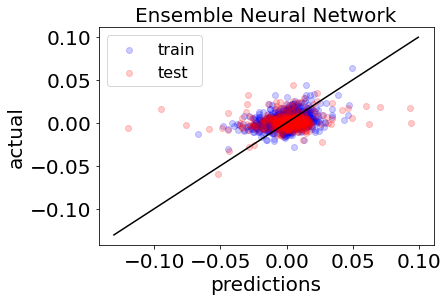

In [38]:
plt.scatter(train_targets,train_preds, alpha=0.2, color='b',label='train')
plt.scatter(test_targets,test_preds, alpha=0.2, color='r',label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
plt.rcParams['font.size']='16'
# Set the axis labels and show the plot
plt.xlabel('predictions',fontsize = 20)
plt.ylabel('actual',fontsize = 20)
plt.title('Ensemble Neural Network',fontsize = 20)
plt.legend()
plt.show()

In [19]:
df_spx = pd.read_csv('../s&p_return.csv')

In [20]:
df = pd.read_csv('NN_ensembling_return.csv')
df = df.dropna()
df

,year,point,train_rmse,test_rmse
0,2011,665,0.009564,0.016252
1,2012,260,0.009564,0.016252
2,2013,378,0.009564,0.016252
3,2014,392,0.009564,0.016252
4,2015,716,0.009564,0.016252
5,2016,539,0.009564,0.016252
6,2017,387,0.009564,0.016252
7,2018,172,0.009564,0.016252
8,2019,748,0.009564,0.016252
9,2020,931,0.009564,0.016252


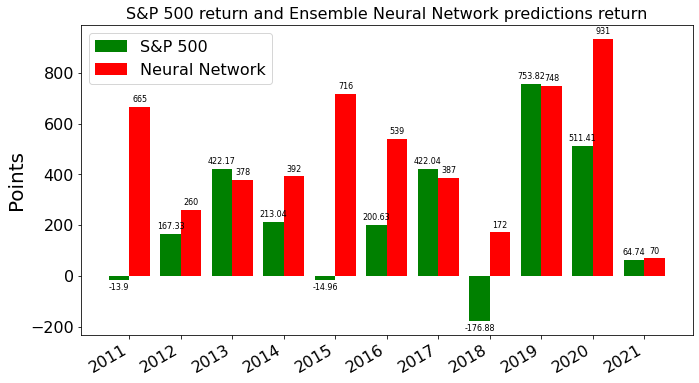

In [41]:
labels = ['2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020','2021']
x = np.arange(len(df['year']))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2,df_spx['point'], width, label='S&P 500',color ='g')
rects2 = ax.bar(x + width/2,df['point'] , width, label='Neural Network', color = 'r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Points',fontsize = 20)
ax.set_title('S&P 500 return and Ensemble Neural Network predictions return',fontsize = 16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=8 )
ax.bar_label(rects2, padding=3, fontsize=8 )

fig.tight_layout()
plt.rcParams['font.size']='16'
plt.legend(loc =2,prop={'size':16})
fig.autofmt_xdate()
plt.savefig('NN_ensembling_return.png',dpi=300)
plt.show()

In [23]:
df_return.to_csv('df_return_NN.csv')

In [24]:
df_vs_features =['Date','close','predictions']
df_vs = df_return[df_vs_features]
df_vs.head(5)

,Date,close,predictions
0,2011-06-20,1278.36,-0.002857
1,2011-06-21,1295.52,-0.004317
2,2011-06-22,1287.14,0.003846
3,2011-06-23,1283.50,0.000502
4,2011-06-24,1268.45,0.004726


In [25]:
df_vs['pClose'] = df_vs['close']*(1+df_vs['predictions'])

<ipython-input-25-e78ad7227175>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
df_vs.head(5)

,Date,close,predictions,pClose
0,2011-06-20,1278.36,-0.002857,1274.708374
1,2011-06-21,1295.52,-0.004317,1289.927568
2,2011-06-22,1287.14,0.003846,1292.090097
3,2011-06-23,1283.50,0.000502,1284.144764
4,2011-06-24,1268.45,0.004726,1274.444912


In [27]:
df_vs['pClose'] = df_vs['pClose'].shift(1)
df_vs.head(5)

<ipython-input-27-90c0fa3be022>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,close,predictions,pClose
0,2011-06-20,1278.36,-0.002857,NaN
1,2011-06-21,1295.52,-0.004317,1274.708374
2,2011-06-22,1287.14,0.003846,1289.927568
3,2011-06-23,1283.50,0.000502,1292.090097
4,2011-06-24,1268.45,0.004726,1284.144764


In [28]:
df_vs = df_vs.dropna()

In [37]:
def graphCompare(start_date,end_date):
    df_point_compare = df_vs.loc[df_vs['Date'].between(start_date,end_date,inclusive=False)]
    df_point_compare=df_point_compare.reset_index()
    #print(df_point_compare)
    fig = plt.figure(figsize=(20,6))
    plt.rcParams['font.size']='20'
    plt.legend(loc =2,prop={'size':20})  
    plt.plot(df_point_compare['Date'],df_point_compare['close'],label='Real')
    plt.plot(df_point_compare['Date'],df_point_compare['pClose'],label='Prediction')
    #plt.xlabel('2011-2018')
    #plt.tick_params(axis='x',labelrotation=20)
    fig.autofmt_xdate()
    plt.ylabel('Points',fontsize = 20)
    plt.title('S&P 500 & Ensemble Neural Network : '+start_date+'-'+end_date,fontsize = 25)
    plt.legend()
  #  plt.figure(figsize=(20,6))
    #plt.set_size_inches(10,5)
    plt.savefig('predict-'+start_date+'-'+end_date+'.png')
    plt.show()

No handles with labels found to put in legend.


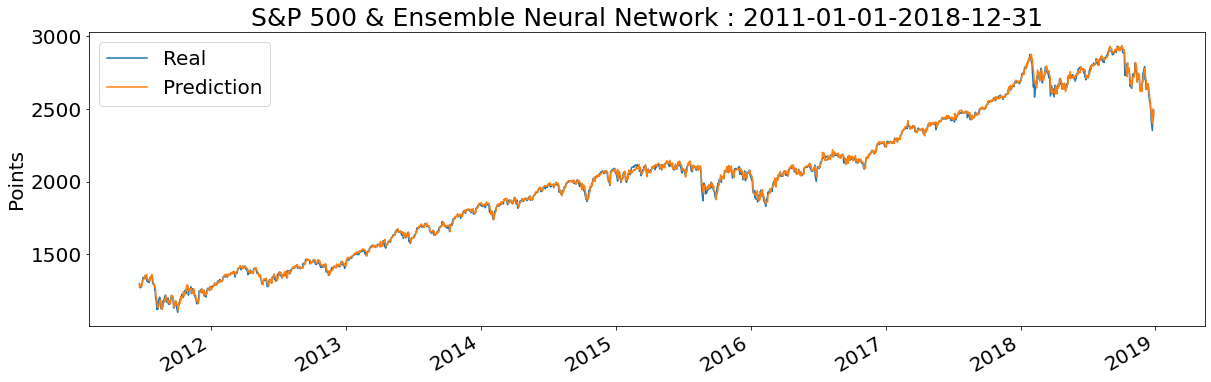

No handles with labels found to put in legend.


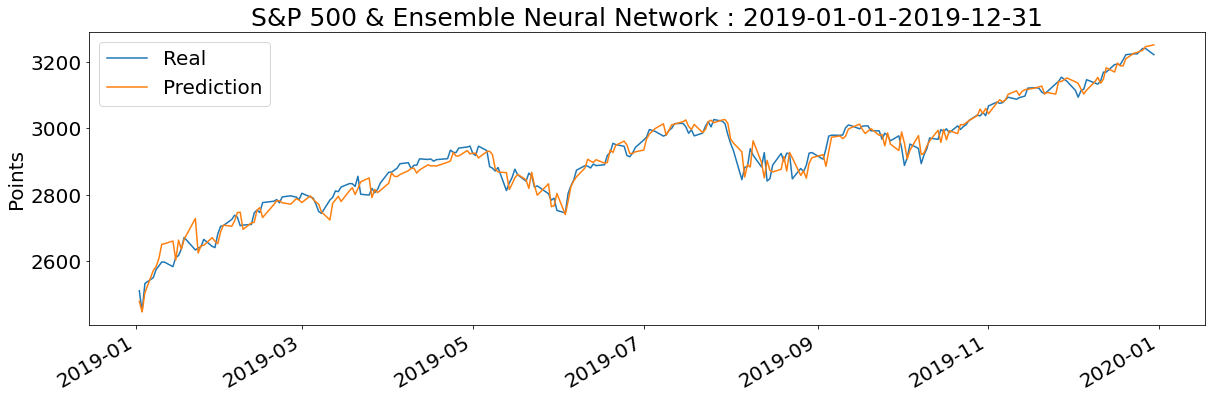

No handles with labels found to put in legend.


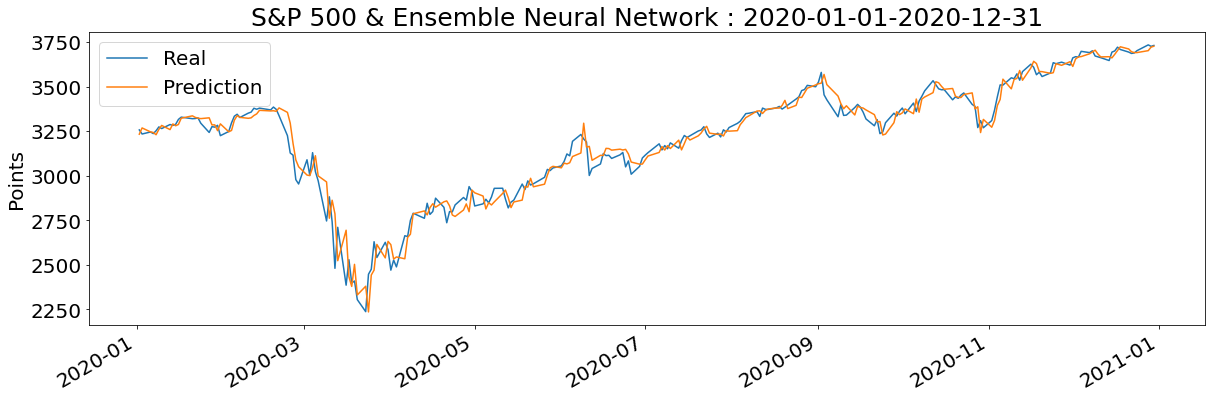

No handles with labels found to put in legend.


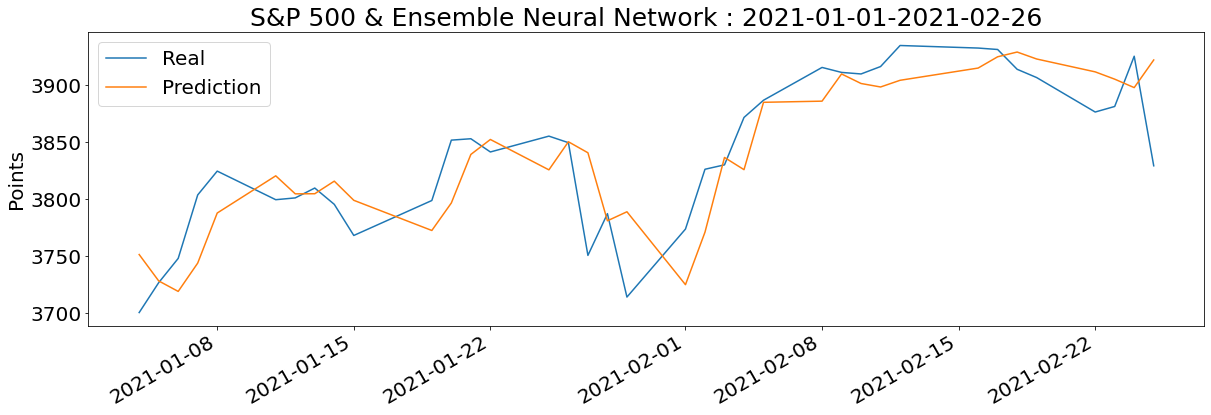

In [39]:
graphCompare("2011-01-01","2018-12-31")
graphCompare("2019-01-01","2019-12-31")
graphCompare("2020-01-01","2020-12-31")
graphCompare("2021-01-01","2021-02-26")

In [43]:
def showBuySell(start_date,end_date):
    df_point_compare = df_return.loc[df_return['Date'].between(start_date,end_date,inclusive=False)]
    
   # df_point_compare = df_point_compare.reset_index()
 #   df_point_compare.head(10)
    fig = plt.figure(figsize=(20,6),dpi=300)
    plt.rcParams['font.size']='20'
    plt.legend(loc =2,prop={'size':20})      
    plt.plot(df_point_compare['Date'],df_point_compare['close'],label='S&P 500')
    fig.autofmt_xdate()
    plt.scatter(df_point_compare.loc[df_point_compare['signal'] =='buy' , 'Date'].values,df_point_compare.loc[df_point_compare['signal'] =='buy', 'close'].values, label='Buy', color='green', s=64, marker="^")
    plt.scatter(df_point_compare.loc[df_point_compare['signal'] =='sell' , 'Date'].values,df_point_compare.loc[df_point_compare['signal'] =='sell', 'close'].values, label='Sell', color='red', s=64, marker="v")
    plt.ylabel('Points',fontsize=20)
    plt.title('Ensemble Neural Network buy and sell signal: '+start_date+'-'+end_date)
    plt.legend()
    plt.savefig('BuySell-'+start_date+'-'+end_date+'.png')

    #df_point_compare.to_csv('point_compare.csv')
    #plt.set_size_inches(10,5)
    plt.show()
 

No handles with labels found to put in legend.


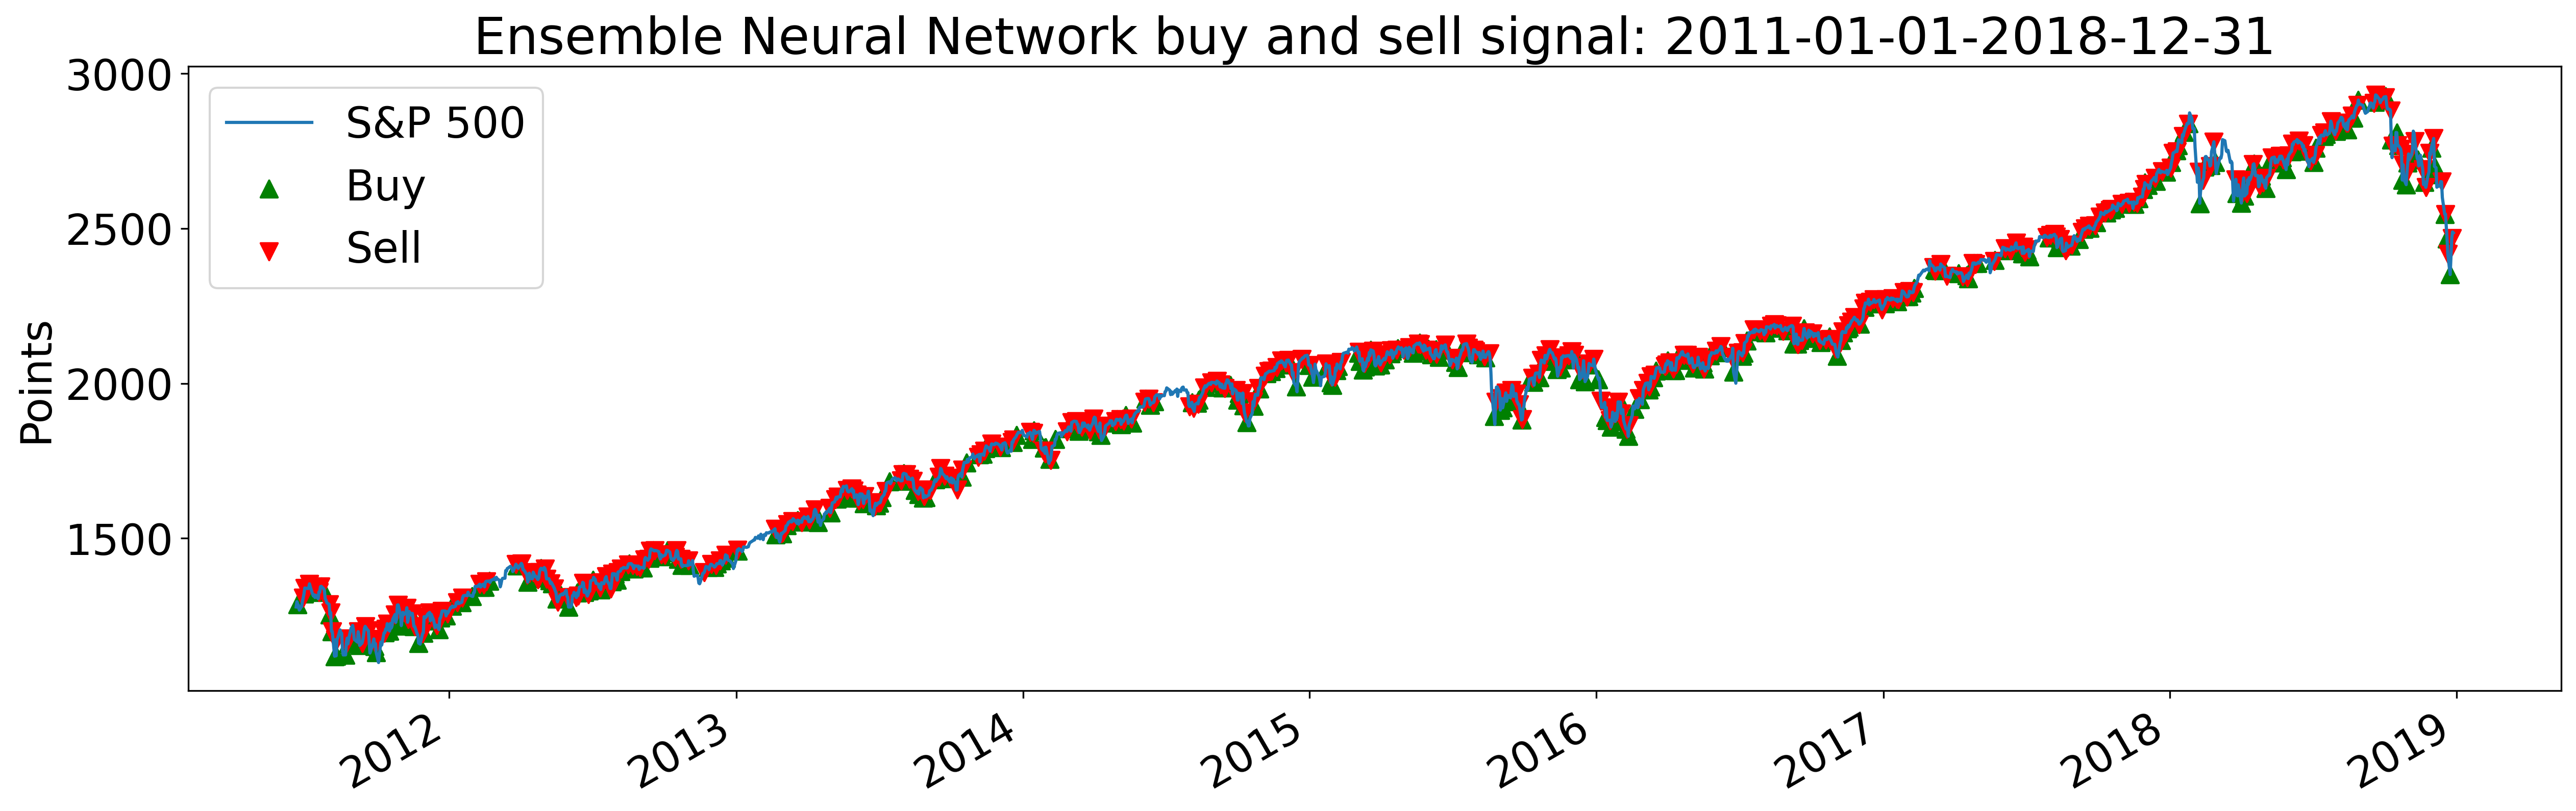

No handles with labels found to put in legend.


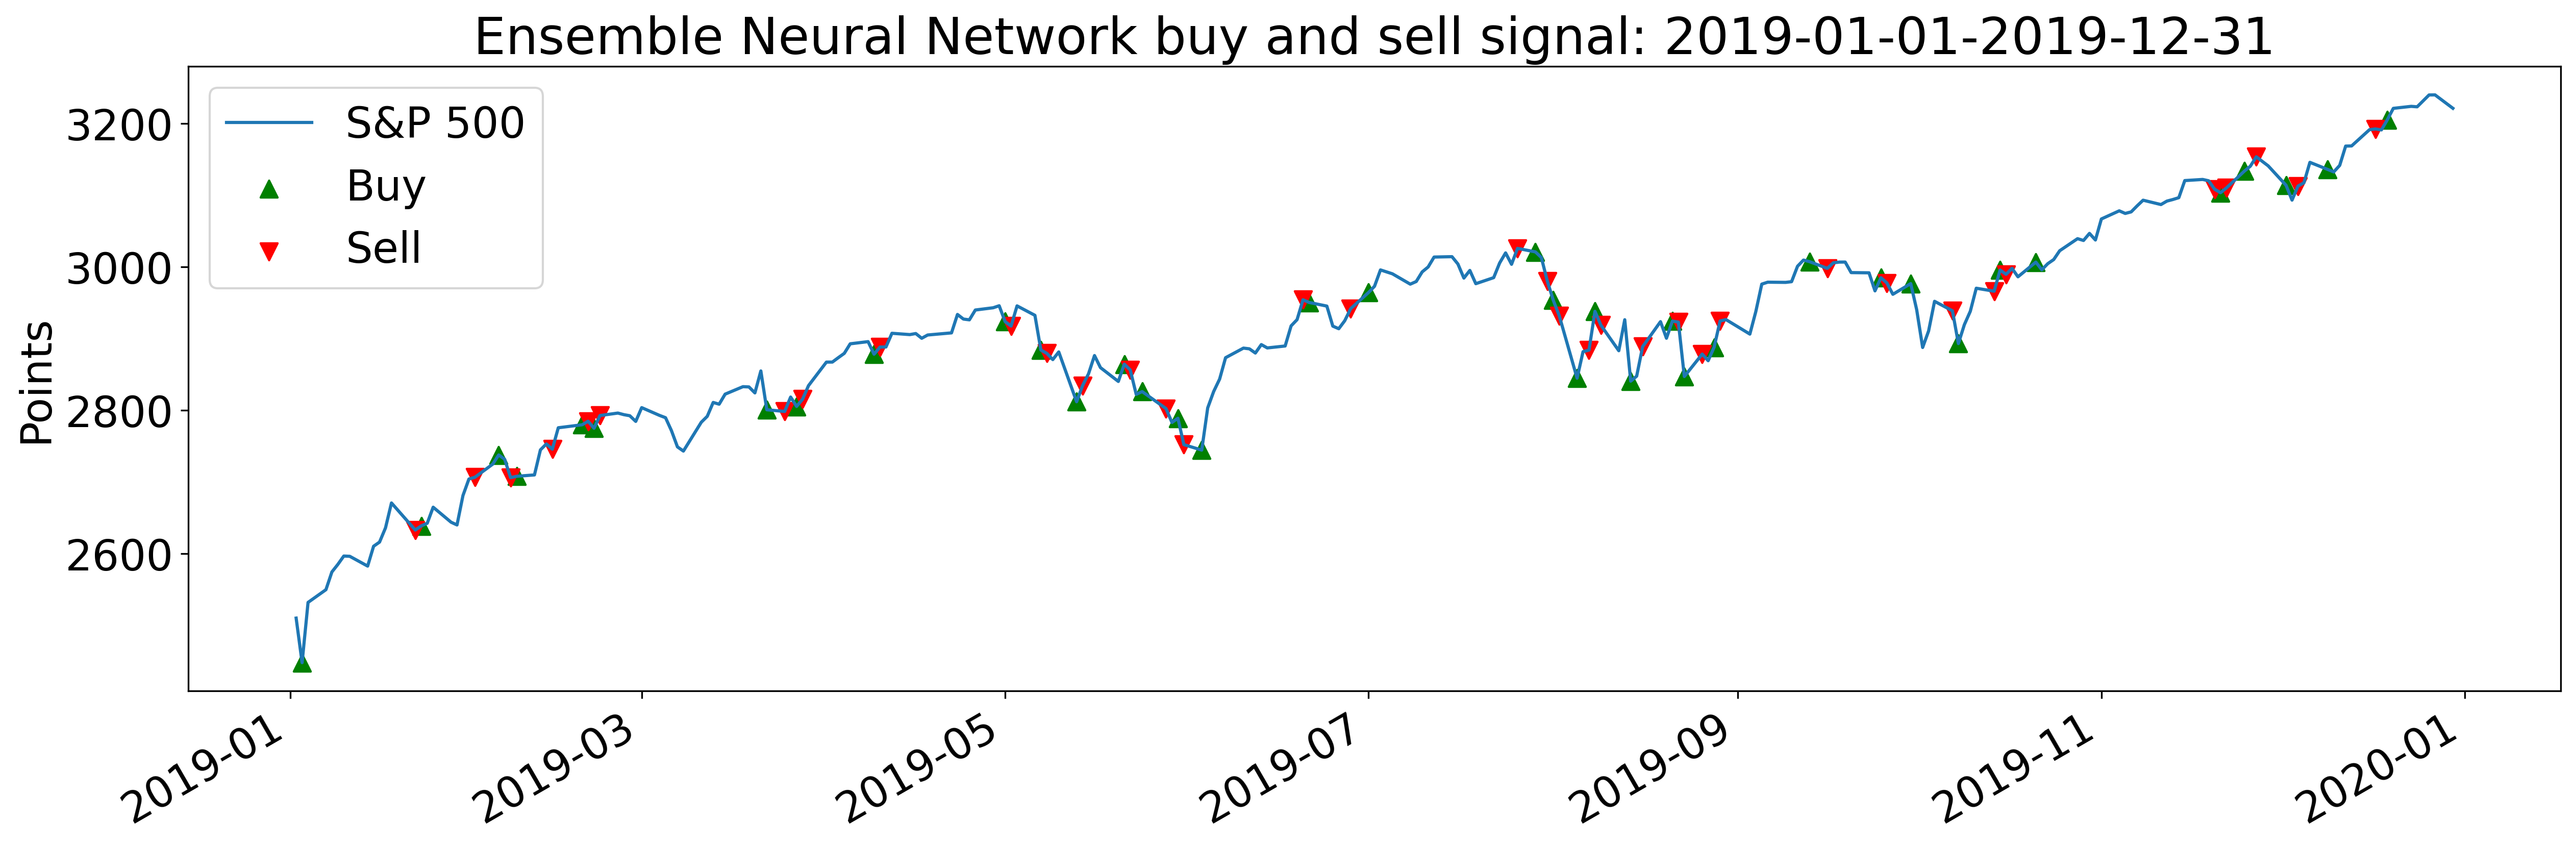

No handles with labels found to put in legend.


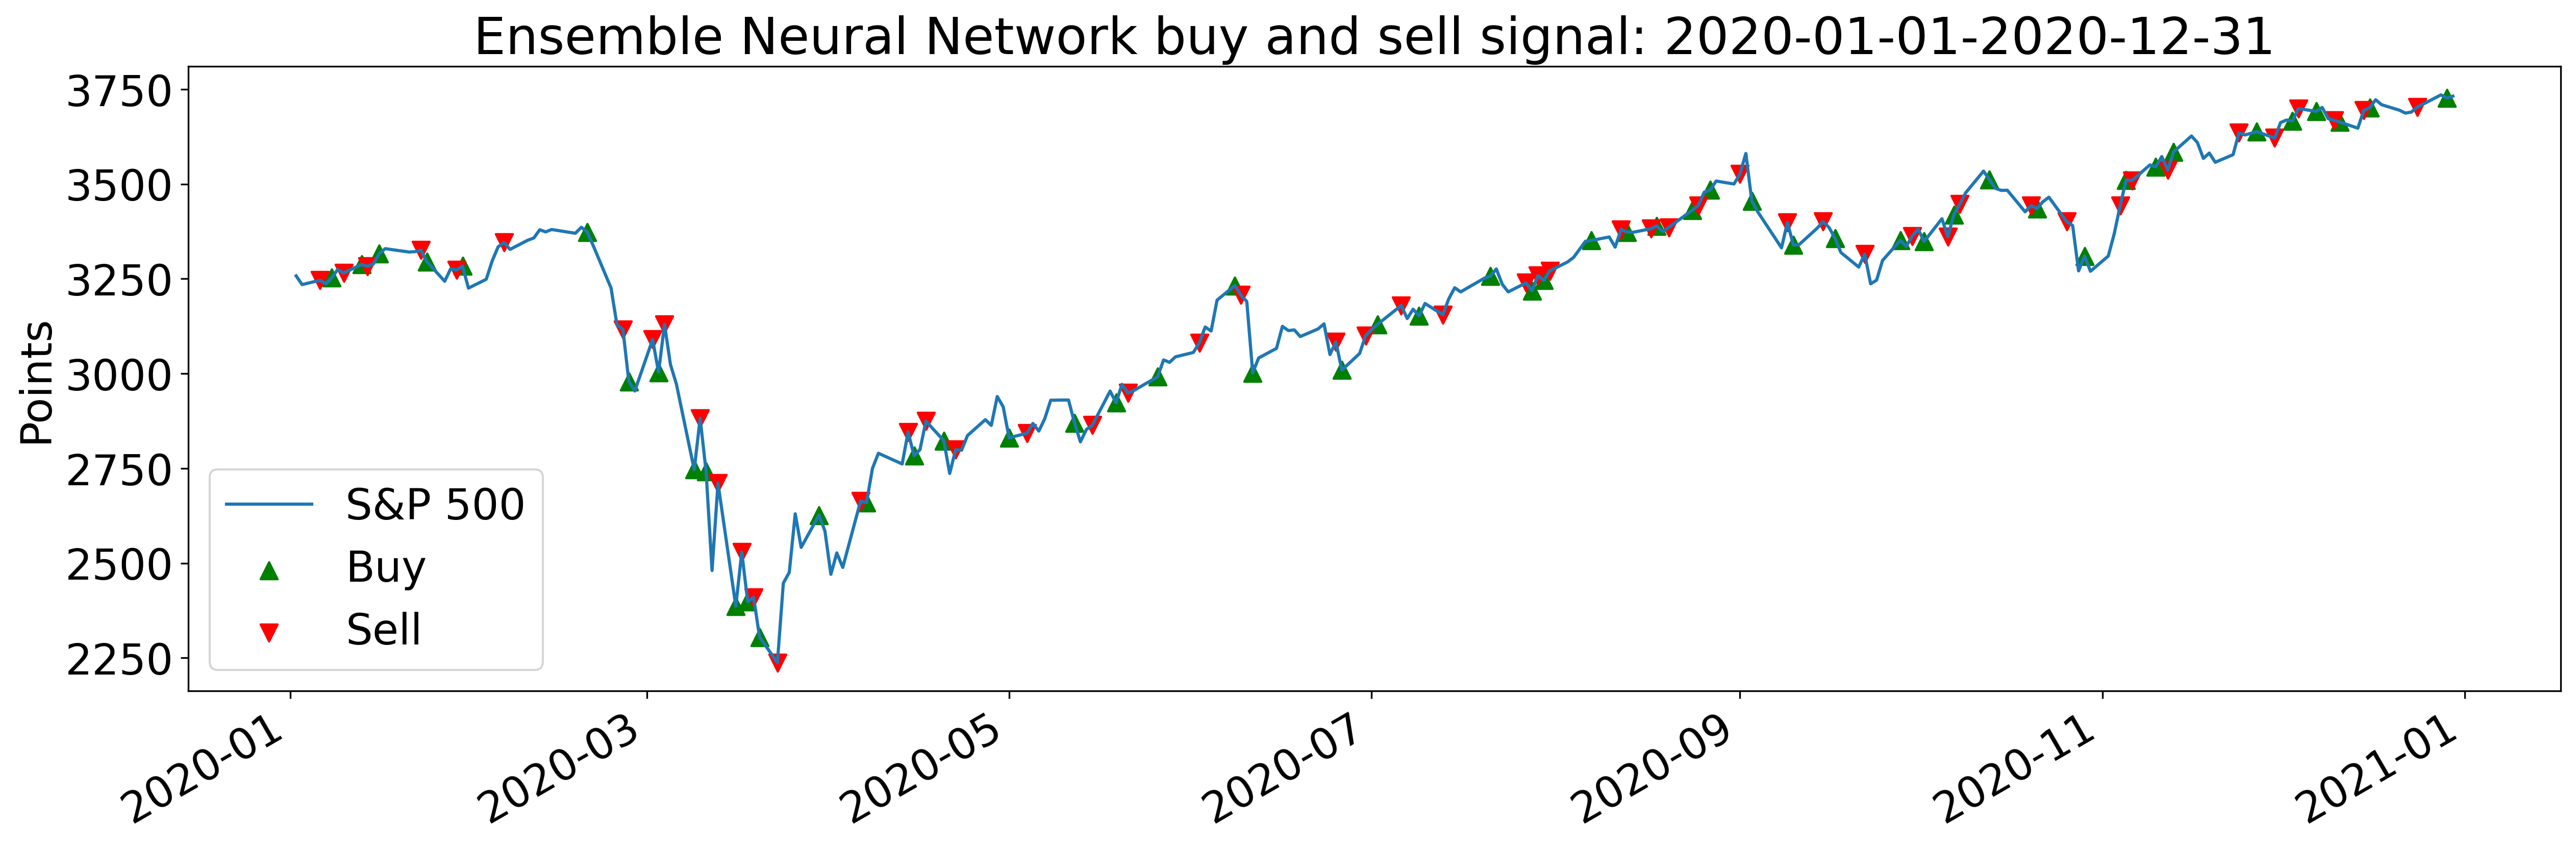

No handles with labels found to put in legend.


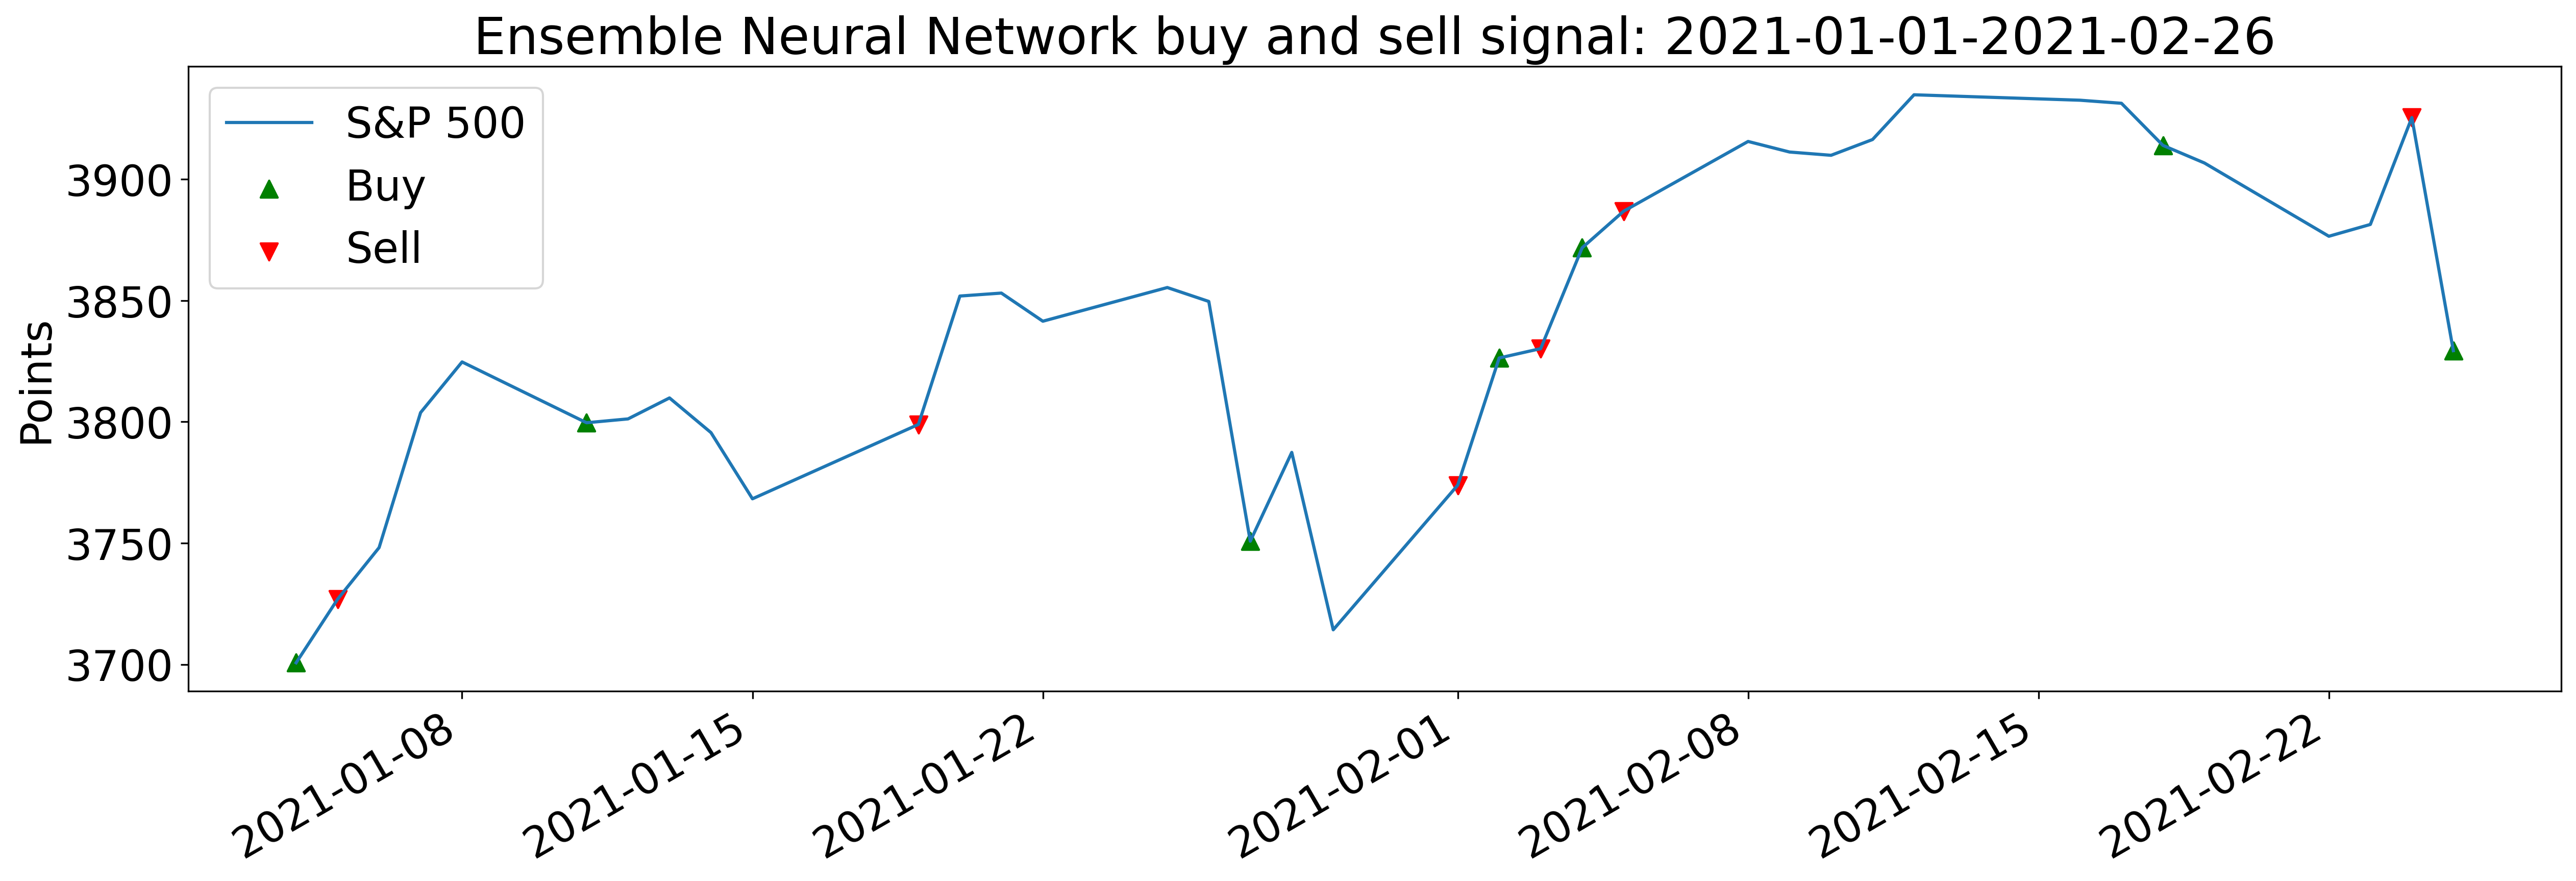

In [44]:
showBuySell("2011-01-01","2018-12-31")
showBuySell("2019-01-01","2019-12-31")
showBuySell("2020-01-01","2020-12-31")
showBuySell("2021-01-01","2021-02-26")